# Pleiades-Workprecision

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-Pleiades">
             Initial value problem: Pleiades</a></li>     
                          
<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Work-Precision-diagrams">
             Work-Precision diagrams</a></li> 

             
<li><a href="#Save-Data">
            Save Data</a></li>  

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO
using RecursiveArrayTools

In [6]:
#plotly()

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

2

In [8]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

2

<a href="#top">Back to the top</a>

## Initial value problem: Pleiades

In [4]:
setprecision(BigFloat, 108);
include("../examples/Pleiades.jl")
include("../examples/InitialPleiades.jl")

t0=0.0
t1=10*1/1000  #3.0
t1=3.0

u064 =InitialPleiades(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(f,u064,tspan64);

u0128=InitialPleiades(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(f,u0128,tspan128);
(typeof(u064),typeof(tspan64),typeof(u0128),typeof(tspan128))

q064=copy(u064[1:14])
v064=copy(u064[15:28])
probdyn64 = DynamicalODEProblem(dotq,dotv,q064,v064,tspan64)
prob2nd64 = SecondOrderODEProblem(f2nd!,v064,q064,tspan64)


q0128=copy(u0128[1:14])
v0128=copy(u0128[15:28])
probdyn128 = DynamicalODEProblem(dotq,dotv,q0128,v0128,tspan128)
prob2nd128 = SecondOrderODEProblem(f2nd!,v0128,q0128,tspan128);

<a href="#top">Back to the top</a>

## Test solution

In [5]:
setprecision(BigFloat, 256)
#sol =solve(prob128,Vern9(),save_everystep=false,abstol=1e-32,reltol=1e-32);
#@save "./Data/plei_test_solF128END.jld2" sol

@load "./Data/plei_test_solF128END.jld2" sol
test_sol = TestSolution(sol)
sol.destats

u0256 =InitialPleiades(BigFloat)
Gm256=BigFloat.([1,2,3,4,5,6,7])

E0=NbodyEnergy(u0256,Gm256)
(Float32(sol.t[end]),Float32(NbodyEnergy(sol.u[end],Gm256)/E0.-1))

(3.0f0, 5.9543627f-33)

In [6]:
ux=sol.u[end]
solx=ArrayPartition(ux[1:14], ux[15:28])
test_solx = TestSolution(tspan128,[solx])

ux=sol.u[end]
solx2nd=ArrayPartition(ux[15:28],ux[1:14])
test_solx2nd = TestSolution(tspan128,[solx2nd]);

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

In [7]:
Threads.nthreads()

2

In [8]:
abstols = 1.0 ./ 10.0 .^ (10:17)
reltols = 1.0 ./ 10.0 .^ (10:17);

### Float64 (DynamicalProblem)

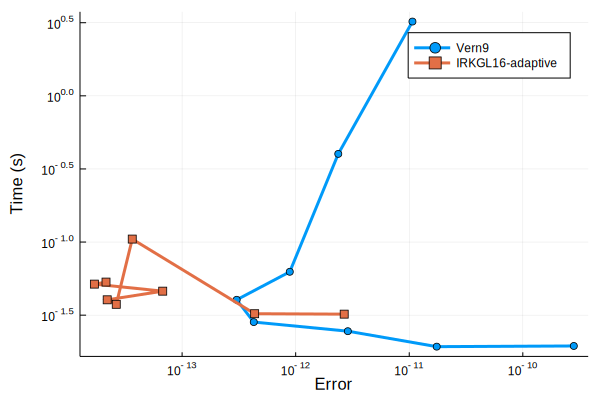

In [10]:
setups = [
          Dict(:alg=>Vern9()),
          Dict(:alg=>IRKGL16(),:adaptive=>true, :mixed_precision=>false)
]
solnames = ["Vern9","IRKGL16-adaptive"]
wp2 = WorkPrecisionSet(probdyn64,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=10^9, names=solnames)
plot(wp2)

### Float64 (SecondOrderProblem)

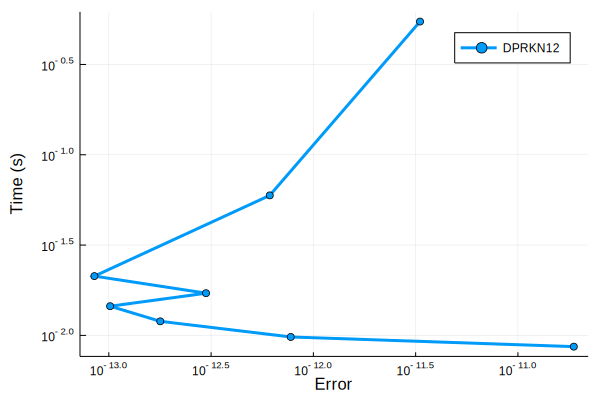

In [11]:
setups = [
          Dict(:alg=>DPRKN12())   
]
solnames=["DPRKN12"]
wp3 = WorkPrecisionSet(prob2nd64,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=1,maxiters=10^9,name=solnames)
plot(wp3)

### Plot: OdeProblem+DynamicalProblem+SecondOrderProblem (Float64)

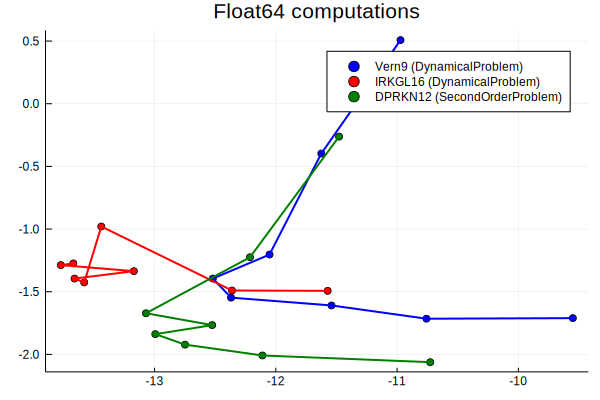

In [13]:
plot(title="Float64 computations")
k=1
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicalProblem)", color="blue")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="", lw=2, color="blue")
# 
k=2
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="IRKGL16 (DynamicalProblem)", color="red")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="", lw=2, color="red")
#
k=1
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), seriestype=:scatter, label="DPRKN12 (SecondOrderProblem)", color="green")
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), label="", lw=2, color="green")

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

In [14]:
now()

2020-06-29T17:47:55.189

In [15]:
setprecision(BigFloat, 108)
abstols = 1.0 ./ 10.0 .^ (12:30)
reltols = 1.0 ./ 10.0 .^ (12:30);

### Float128 (OdeProblem)

In [ ]:
setups = [ Dict(:alg=>Vern9())
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false) 
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>true,:low_prec_type=>Float64)
           Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>true,:low_prec_type=>Float64,:threading=>true)
]
solnames = ["Vern9","IRKGL16-adaptive","IRKGL16-adaptive/mix", "IRKGL16-adaptive/mix/threads" ]
wp11 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1,maxiters=10^9, name=solnames)
plot(wp11)

### Float128 (DynamicalProblem)

In [ ]:
setups = [
          Dict(:alg=>Vern9())
          Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false) 
          Dict(:alg=>IRKGL16(),:adaptive=>true,:mixed_precision=>false,:threading=>true) 
]
solnames=["Vern9", "IRKGL16-adaptive", "IRKGL16-adaptive/thread"]
wp12 = WorkPrecisionSet(probdyn128,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=10^9,names=solnames)
plot(wp12)

### Float128 (SecondOrderProblem)

In [ ]:
ux=sol.u[end]
solx=ArrayPartition(ux[15:28],ux[1:14])
test_solx = TestSolution(tspan128,[solx]);

In [ ]:
setups = [
          Dict(:alg=>DPRKN12())   
]
solnames=["DPRKN12"]
wp13 = WorkPrecisionSet(prob2nd128,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=1,maxiters=10^9,names=solnames)
plot(wp13)

### Plot: OdeProblem+DynamicalProblem+SecondOrderProblem

In [ ]:
k=1
plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="Vern9 (OdeProblem)")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="")
# 
k=1
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicProblem)")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="")

In [ ]:
k=2
plot(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16 (OdeProblem)", color="red")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="", color="red")
#
k=3
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX (OdeProblem)",  color="orange")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="",  color="orange")
#
k=4
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX-Thread(OdeProblem)",  color="blue")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="",  color="blue")
# 
k=2
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="IRKGL16 (DynamicProblem)",  color="green")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="", color="green")
# 
k=3
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="IRKGL16-Thread (DynamicProblem)",  color="black")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="", color="black")

In [ ]:
k=1
plot(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="Vern9 (DynamicProblem)", color="blue")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="",color="blue")
#
k=3
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX (OdeProblem)", color="red")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="" , color="red")
#
k=4
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), seriestype=:scatter, label="IRKGL16-MIX-thread (OdeProblem)", color="orange")
plot!(log10.(wp11.wps[k].errors),log10.(wp11.wps[k].times), label="" , color="orange")
# 
k=3
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), seriestype=:scatter, label="IRKGL16-Thread (DynamicProblem)",  color="black")
plot!(log10.(wp12.wps[k].errors),log10.(wp12.wps[k].times), label="", color="black")
#
k=1
plot!(log10.(wp13.wps[k].errors),log10.(wp13.wps[k].times), seriestype=:scatter, label="DPRKN12 (2OdeProblem)", color="green")
plot!(log10.(wp13.wps[k].errors),log10.(wp13.wps[k].times), label="", color=green)


<a href="#top">Back to the top</a>

### Save Data

In [ ]:
 Float64 experiments
@save "./Data/output/OutPleiades_wp2.jld2" wp2
@save "./Data/output/OutPleiades_wp3.jld2" wp3
# Float128 experiments
@save "./Data/output/OutPleiades_wp11.jld2" wp11
@save "./Data/output/OutPleiades_wp12.jld2" wp12
@save "./Data/output/OutPleiades_wp13.jld2" wp13

In [ ]:
# Float64 experiments
#@load "./Data/output/OutPleiades_wp2.jld2" wp2
#@load "./Data/output/OutPleiades_wp3.jld2" wp3
# Float128 experiments
#@load "./Data/output/OutPleiades_wp11.jld2" wp11
#@load "./Data/output/OutPleiades_wp12.jld2" wp12
#@load "./Data/output/OutPleiades_wp13.jld2" wp13

In [ ]:
now()